<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Analyze-viral-barcodes-from-barcode-specific-Illumina-sequencing" data-toc-modified-id="Analyze-viral-barcodes-from-barcode-specific-Illumina-sequencing-1">Analyze viral barcodes from barcode-specific Illumina sequencing</a></span><ul class="toc-item"><li><span><a href="#Setup-for-analysis" data-toc-modified-id="Setup-for-analysis-1.1">Setup for analysis</a></span><ul class="toc-item"><li><span><a href="#Parameters" data-toc-modified-id="Parameters-1.1.1">Parameters</a></span></li><li><span><a href="#Import-Python-modules" data-toc-modified-id="Import-Python-modules-1.1.2">Import Python modules</a></span></li><li><span><a href="#Temporary-way-to-read-in-parameters" data-toc-modified-id="Temporary-way-to-read-in-parameters-1.1.3">Temporary way to read in parameters</a></span></li></ul></li><li><span><a href="#Parse-the-viral-barcodes" data-toc-modified-id="Parse-the-viral-barcodes-1.2">Parse the viral barcodes</a></span></li><li><span><a href="#Examine-&quot;fates&quot;-of-barcode-reads" data-toc-modified-id="Examine-&quot;fates&quot;-of-barcode-reads-1.3">Examine "fates" of barcode reads</a></span></li><li><span><a href="#Examine-distribution-of-barcodes" data-toc-modified-id="Examine-distribution-of-barcodes-1.4">Examine distribution of barcodes</a></span></li><li><span><a href="#Rarefaction-curves-for-barcodes" data-toc-modified-id="Rarefaction-curves-for-barcodes-1.5">Rarefaction curves for barcodes</a></span></li></ul></li></ul></div>

# Analyze viral barcodes from barcode-specific Illumina sequencing
This Python Jupyter notebook process Illumina sequencing of just the viral barcodes that have been amplified by specific PCR of that region.

# Goal
The goal of this notebook is to compare a variety of rescue conditions. We'd like to learn something about the best practices for rescuing, with the most largest bottleneck.

## Setup for analysis

### Parameters
The next cell is tagged as a `parameters` cell.
That means that when you run with [papermill parameterization](https://papermill.readthedocs.io/en/latest/usage.html#parameterizing-a-notebook), there will be a cell inserted immediately after it with the actual parameterized values for these inputs parameters.

The cell must specify:
 - `sample_csv`: CSV file that lists *sample*, *gene*, *datafile* (location of R1 FASTQ files), and *datatype*. We only consider rows of *datatype* equal to *viral_barcode_fastqs*.
 - `barcodelength`: length of the viral barcodes.
 - `upstream`: dict keyed by each gene, with values being the upstream sequence
 - `downstream`: dict keyed by each gene, with values being the downstream sequence
 - `upstream_mismatch`: allowed mismatches upstream
 - `downstream_mismatch`: allowed mismatched downstream
 - `viral_barcode_counts`: created CSV file in tidy format where columns are *sample*, *viral_barcode*, *count*

For now, the cell is just empty as the values will be set by `papermill`.

In [1]:
# Parameters cell

### Import Python modules
Use [dms_tools2](https://jbloomlab.github.io/dms_tools2/) for barcode parsing and [plotnine](https://plotnine.readthedocs.io) for ggplot2-like plotting:

In [2]:
import glob
import os
import yaml
import pandas as pd
from IPython.display import display, HTML
from plotnine import *
import dms_tools2

### Temporary way to read in parameters
For now, just read parameters from `config.yaml` since we aren't yet parameterizing notebook:

In [3]:
with open('config.yaml') as f:
    config = yaml.load(f)
    
upstream = config['viral_barcode_upstream']
downstream = config['viral_barcode_downstream']
upstream_mismatch = config['viral_barcode_upstream_mismatch']
downstream_mismatch = config['viral_barcode_downstream_mismatch']
barcodelength = config['viral_barcode_length']

sample_csv = 'sampledata.csv'

## Parse the viral barcodes
The viral barcodes and their data locations are specified in *sample_csv*. Here, we read them in.

In [4]:
samples = pd.read_csv(sample_csv,comment="#").query('datatype == "viral_barcode_fastqs"')

pd.set_option('max.colwidth', -1)
display(HTML(samples.to_html(index=False)))

sample,datatype,gene,datafile
fluHA_virus_transfection_1,viral_barcode_fastqs,fluHA,/shared/ngs/illumina/bloom_lab/190507_M03100_0428_000000000-CG8CT/Data/Intensities/BaseCalls/bcHA-virus-transfection-sample1_S5_L001_R1_001.fastq.gz
fluHA_virus_transfection_2,viral_barcode_fastqs,fluHA,/shared/ngs/illumina/bloom_lab/190507_M03100_0428_000000000-CG8CT/Data/Intensities/BaseCalls/bcHA-virus-transfection-sample2_S6_L001_R1_001.fastq.gz
fluHA_virus_passaged_1,viral_barcode_fastqs,fluHA,/shared/ngs/illumina/bloom_lab/190507_M03100_0428_000000000-CG8CT/Data/Intensities/BaseCalls/bcHA-virus-passaged-sample1_S7_L001_R1_001.fastq.gz
fluHA_virus_passaged_2,viral_barcode_fastqs,fluHA,/shared/ngs/illumina/bloom_lab/190507_M03100_0428_000000000-CG8CT/Data/Intensities/BaseCalls/bcHA-virus-passaged-sample2_S8_L001_R1_001.fastq.gz
m-WTBC-monster-Mike-cc,viral_barcode_fastqs,fluNA,"/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190306_M04866_0224_000000000-C89KK/Data/Intensities/BaseCalls/m-WTBC-monster-Mike-cc_S10_L001_R1_001.fastq.gz,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190311_M03100_0402_000000000-CC72D/Data/Intensities/BaseCalls/ag-m-WTBC-monster-Mike-cc_S10_L001_R1_001.fastq.gz"
m-WTBC-monster-Mike-OL,viral_barcode_fastqs,fluNA,"/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190306_M04866_0224_000000000-C89KK/Data/Intensities/BaseCalls/m-WTBC-monster-Mike-OL_S11_L001_R1_001.fastq.gz,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190311_M03100_0402_000000000-CC72D/Data/Intensities/BaseCalls/ag-m-WTBC-monster-Mike-OL_S11_L001_R1_001.fastq.gz"
m-WTBC-monster-pCAWS-cc,viral_barcode_fastqs,fluNA,"/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190306_M04866_0224_000000000-C89KK/Data/Intensities/BaseCalls/m-WTBC-monster-pCAWS-cc_S12_L001_R1_001.fastq.gz,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190311_M03100_0402_000000000-CC72D/Data/Intensities/BaseCalls/ag-m-WTBC-monster-pCAWS-cc_S12_L001_R1_001.fastq.gz"
m-WTBC-monster-pCAWS-OL,viral_barcode_fastqs,fluNA,"/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190306_M04866_0224_000000000-C89KK/Data/Intensities/BaseCalls/m-WTBC-monster-pCAWS-OL_S13_L001_R1_001.fastq.gz,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190311_M03100_0402_000000000-CC72D/Data/Intensities/BaseCalls/ag-m-WTBC-monster-pCAWS-OL_S13_L001_R1_001.fastq.gz"
m-WTBC-pHW-cc-2ug,viral_barcode_fastqs,fluNA,"/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190306_M04866_0224_000000000-C89KK/Data/Intensities/BaseCalls/m-WTBC-pHW-cc-2ug_S14_L001_R1_001.fastq.gz,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190311_M03100_0402_000000000-CC72D/Data/Intensities/BaseCalls/ag-m-WTBC-pHW-cc-2ug_S14_L001_R1_001.fastq.gz"
m-WTBC-pHW-cc-4ug,viral_barcode_fastqs,fluNA,"/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190306_M04866_0224_000000000-C89KK/Data/Intensities/BaseCalls/m-WTBC-pHW-cc-4ug_S15_L001_R1_001.fastq.gz,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190311_M03100_0402_000000000-CC72D/Data/Intensities/BaseCalls/ag-m-WTBC-pHW-cc-4ug_S15_L001_R1_001.fastq.gz"


Read all the barcodes into a data frame using the [dms_tools2.barcodes.IlluminaBarcodeParser](https://jbloomlab.github.io/dms_tools2/dms_tools2.barcodes.html#dms_tools2.barcodes.IlluminaBarcodeParser):

In [5]:
barcodes = []
fates = []

for tup in samples.itertuples(index=False):

    parser = dms_tools2.barcodes.IlluminaBarcodeParser(
                bclen=barcodelength,
                upstream=upstream[tup.gene],
                downstream=downstream[tup.gene],
                upstream_mismatch=upstream_mismatch,
                downstream_mismatch=downstream_mismatch)

    if '.fastq.gz' in tup.datafile:
        r1files = tup.datafile.split(',')
    else:
        r1files = glob.glob(os.path.join(tup.datafile, '*R1*.fastq.gz'))
    
    assert len(r1files)
       
    print(f"\nReading viral barcodes for {tup.sample} from {len(r1files)} R1 files")
    print("The files are:")
    print(*r1files, sep = "\n")
    
    ibarcodes, ifates = parser.parse(r1files)
    
    barcodes.append(ibarcodes.assign(sample=tup.sample))
    fates.append(ifates.assign(sample=tup.sample))
    
barcodes = pd.concat(barcodes)
fates = pd.concat(fates)


Reading viral barcodes for fluHA_virus_transfection_1 from 1 R1 files
The files are:
/shared/ngs/illumina/bloom_lab/190507_M03100_0428_000000000-CG8CT/Data/Intensities/BaseCalls/bcHA-virus-transfection-sample1_S5_L001_R1_001.fastq.gz

Reading viral barcodes for fluHA_virus_transfection_2 from 1 R1 files
The files are:
/shared/ngs/illumina/bloom_lab/190507_M03100_0428_000000000-CG8CT/Data/Intensities/BaseCalls/bcHA-virus-transfection-sample2_S6_L001_R1_001.fastq.gz

Reading viral barcodes for fluHA_virus_passaged_1 from 1 R1 files
The files are:
/shared/ngs/illumina/bloom_lab/190507_M03100_0428_000000000-CG8CT/Data/Intensities/BaseCalls/bcHA-virus-passaged-sample1_S7_L001_R1_001.fastq.gz

Reading viral barcodes for fluHA_virus_passaged_2 from 1 R1 files
The files are:
/shared/ngs/illumina/bloom_lab/190507_M03100_0428_000000000-CG8CT/Data/Intensities/BaseCalls/bcHA-virus-passaged-sample2_S8_L001_R1_001.fastq.gz

Reading viral barcodes for m-WTBC-monster-Mike-cc from 2 R1 files
The files

## Examine "fates" of barcode reads
We look at how many of the barcode reads we could parse:

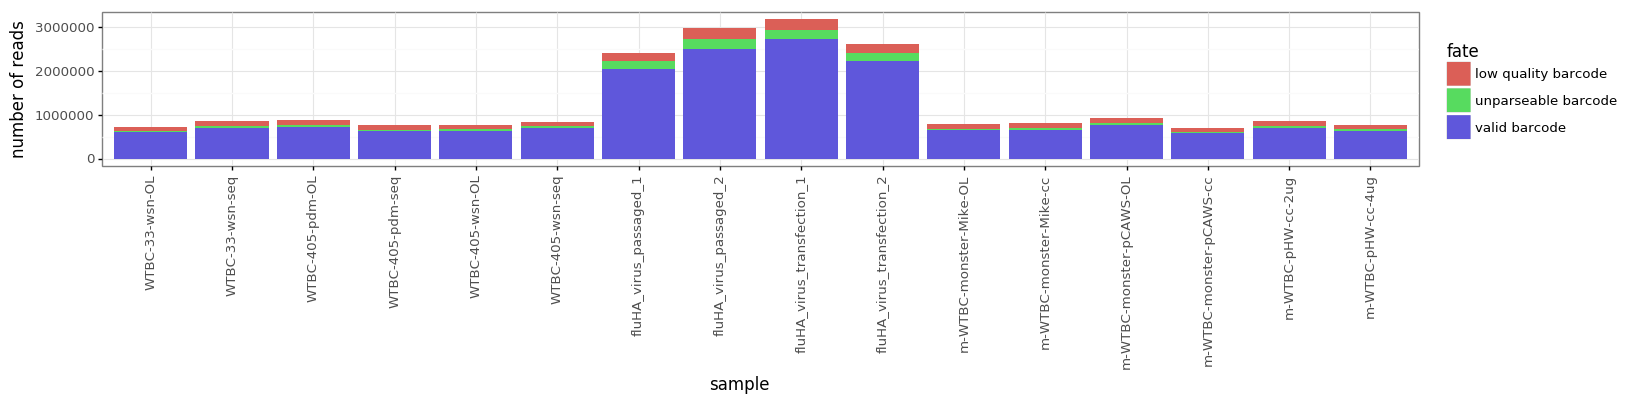

In [6]:
p = (
    ggplot(fates, aes('sample', 'count', fill='fate')) +
    geom_bar(stat='identity', position="stack") +
    ylab('number of reads') +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(1 + len(fates['sample'].unique()), 2)) 
    )
_ = p.draw()

In [7]:
fates

,fate,count,sample
0,valid barcode,2725406,fluHA_virus_transfection_1
1,low quality barcode,245822,fluHA_virus_transfection_1
2,unparseable barcode,215111,fluHA_virus_transfection_1
0,valid barcode,2228610,fluHA_virus_transfection_2
1,low quality barcode,216755,fluHA_virus_transfection_2
2,unparseable barcode,175690,fluHA_virus_transfection_2
0,valid barcode,2051889,fluHA_virus_passaged_1
1,low quality barcode,181161,fluHA_virus_passaged_1
2,unparseable barcode,174560,fluHA_virus_passaged_1
0,valid barcode,2504792,fluHA_virus_passaged_2


## Examine distribution of barcodes
Next, we want to know how the barcodes are distributed. The goal is to have many different barcodes, all with relatively even distribution.  A big problem would be if a few barcodes make up a large portion of the library.

In [8]:
counts_per_barcode = dms_tools2.codonvarianttable.getCumulVariantsByCount(
                        barcodes,
                        group_cols='sample')

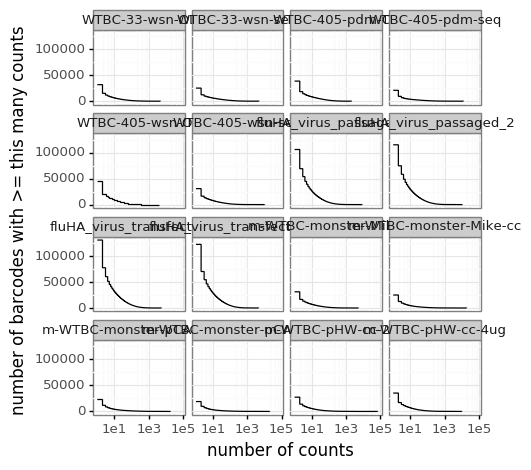

In [9]:
p = (ggplot(counts_per_barcode, aes('count', 'nvariants')) +
     geom_step() +
     scale_x_log10() +
     facet_wrap('~sample') +
     theme(figure_size=(5, 5)) +
     ylab('number of barcodes with >= this many counts') +
     xlab('number of counts')
     )

_ = p.draw()

### Counts for each rank of barcode

Another way to plot this information is to sort the barcodes by rank, and show how many counts the most abundant barcodes have.

In [10]:
p = ggplot(
  counts %>%
    filter(sample == "2-2_6e5_plasmid") %>%
    group_by(sample),
    aes(x=reorder(barcode, -count, sum), y=count)) +
  geom_point(alpha=0.3) +
  scale_y_log10() +
  facet_wrap(~sample, scales = "free") +
  ylab('counts per barcodes') +
  xlab('barcode rank') +
  theme(axis.text.x=element_blank(),
       axis.ticks.x=element_blank())

_ = p.draw()

SyntaxError: invalid syntax (<ipython-input-10-a7bc72166d71>, line 2)

## Rarefaction curves for barcodes

Ultimately, we are not interested in the total number of barcodes, but in ensuring that the barcodes sampled are unique. To study this, we should look at rarefaction curves.

In [11]:
rarefy_df = []
for sample in barcodes['sample'].unique():
    rarefy_df.append(dms_tools2.codonvarianttable.rarefyBarcodes(
                        barcodes.query('sample == @sample'))
                     .assign(sample=sample))
rarefy_df = pd.concat(rarefy_df)

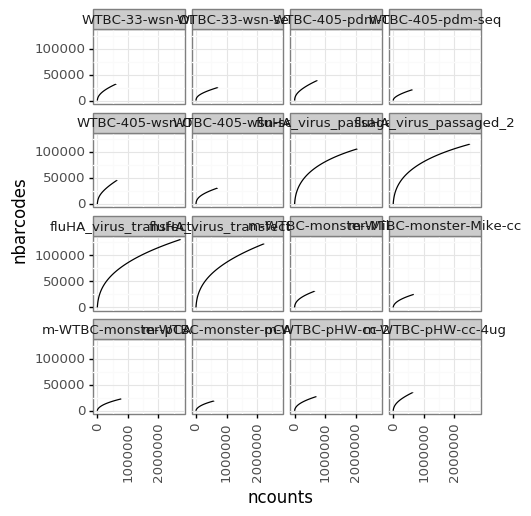

In [12]:
p = (ggplot(rarefy_df, aes('ncounts', 'nbarcodes')) +
     geom_step() +
     facet_wrap('~ sample') +
     theme(figure_size=(5, 5),
           axis_text_x=element_text(angle=90))
     )
_ = p.draw()

/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:74: UserWarning: geom_path: Removed 39525 rows containing missing values.
  warn(msg.format(n1-n2))


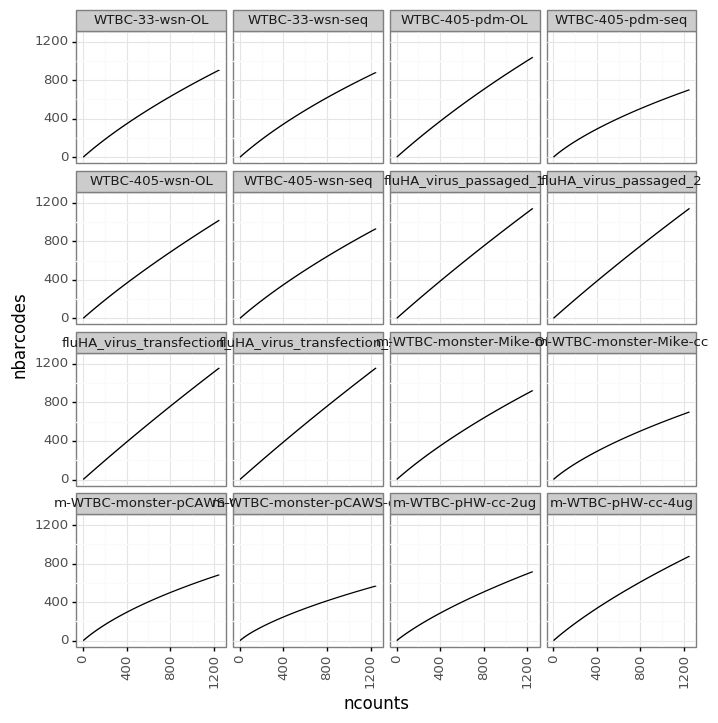

In [20]:
p = (ggplot(rarefy_df, aes('ncounts', 'nbarcodes')) +
     geom_step() +
     facet_wrap('~ sample') +
     theme(figure_size=(8, 8),
           axis_text_x=element_text(angle=90))
     + xlim(0,1250) + ylim(0,1250)
     )
_ = p.draw()

### Evaluating the libraries at a target sample

Let's evaluate the library diversity at a target sample size. For now, I have chosen to use 1000. This exmaines how many of the barcodes in the first 1000 are likely to be unqiue.

In [13]:
nbarcodes_observed = 1000
target_df = rarefy_df.query('ncounts == @nbarcodes_observed')

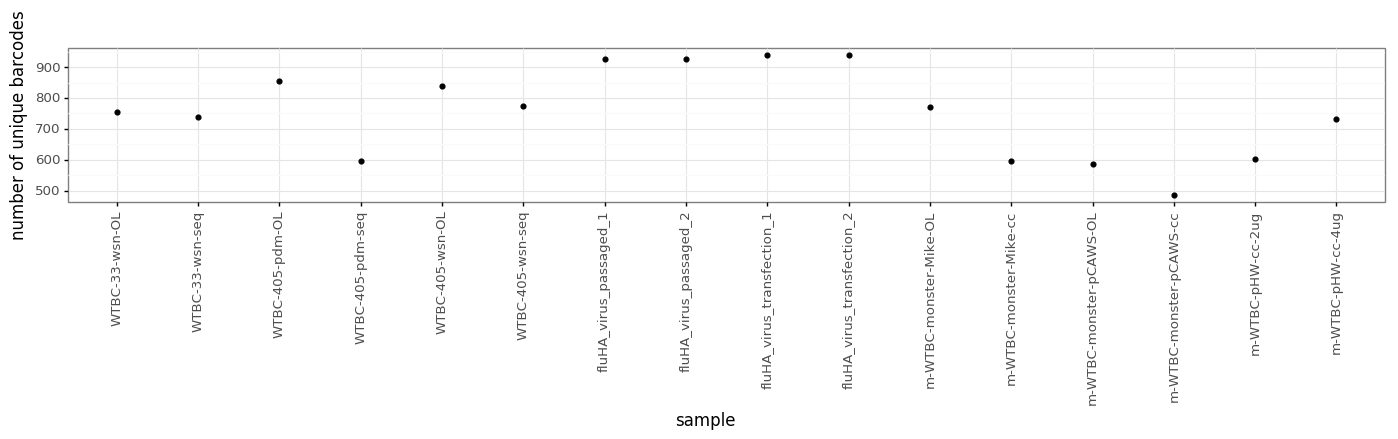

In [14]:
p = (
    ggplot(target_df, aes('sample', 'nbarcodes')) +
    geom_point() +
    ylab('number of unique barcodes') +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(1 + len(fates['sample'].unique()), 2)) 
    )
_ = p.draw()

In [15]:
target_df

,ncounts,nbarcodes,sample
999,1000,939.279310,fluHA_virus_transfection_1
999,1000,939.410859,fluHA_virus_transfection_2
999,1000,927.177556,fluHA_virus_passaged_1
999,1000,927.395491,fluHA_virus_passaged_2
999,1000,595.318253,m-WTBC-monster-Mike-cc
999,1000,769.939226,m-WTBC-monster-Mike-OL
999,1000,485.420088,m-WTBC-monster-pCAWS-cc
999,1000,585.990695,m-WTBC-monster-pCAWS-OL
999,1000,603.323831,m-WTBC-pHW-cc-2ug
999,1000,732.674950,m-WTBC-pHW-cc-4ug
